<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Settings" data-toc-modified-id="Imports-and-Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Settings</a></span></li><li><span><a href="#Configure-Variables" data-toc-modified-id="Configure-Variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configure Variables</a></span></li><li><span><a href="#Begin-Analysis" data-toc-modified-id="Begin-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Begin Analysis</a></span></li></ul></div>

# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
# from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

2023-02-13 12:15:19.620942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("temperature", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("annotated_data/processed_heat_data.csv")
color_channel_to_use = "YL1"
use_stain_in_AutoGater = False

point_1_that_defines_soa_line=(3.25, 4.5)
point_2_that_defines_soa_line=(4, 6.25)

# Begin Analysis

In [6]:
data.columns

Index(['temperature', 'timepoint', 'stain', 'replicate', 'replicate_group', 'FSC-A', 'SSC-A', 'BL1-A', 'BL2-A', 'BL3-A', 'YL4-A', 'YL3-A', 'YL2-A', 'YL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'BL2-H', 'BL3-H', 'YL4-H', 'YL3-H', 'YL2-H', 'YL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'BL2-W', 'BL3-W', 'YL4-W', 'YL3-W', 'YL2-W', 'YL1-W', 'percent_live'], dtype='object')

In [7]:
df = data.loc[(data["stain"] == 1)]

In [8]:
len(data['replicate_group'].unique())

128

In [9]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

print(n)
print(n.morph_cols)
if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that AutoGater will use: {}".format(features))

<class 'autogater_src.names.Names'>
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
Features that AutoGater will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']


In [10]:
print(df[n.temperature].unique())
# df = df[~(df[n.temperature]).isin([40,50])]
print(df[n.temperature].unique())

[25. 30. 35. 40. 45. 50. 55. 65.]
[25. 30. 35. 40. 45. 50. 55. 65.]


In [11]:
df['replicate_group'].value_counts()

560435687fc196e53fe75da8d68a4acf49c1c37f    30000
2026ff6b49221f1a08e70f1e0a37c5f9fd8b227a    30000
5fe84035a4c8e6a6b733762ae3b1d345840ef380    30000
6818ad45a38b91eab6561d376d1cd1e589dd07af    30000
96c4235ee8bad6b5ec3e2856d43fcf7b7cb94a56    30000
                                            ...  
103e26988df5c436922edca0b016e000317de7b3    30000
8288745d132e0902cc6290113f0b09e189410452    30000
fe73dc20a94d898b8e56a412279b24ef83706fa5    30000
f776cf6665606475ca1fdd74eb7104ccdd8ddf6b    30000
1510cd950b126b84e155c13f98d066a367bfefe1    30000
Name: replicate_group, Length: 64, dtype: int64

In [12]:
geo_means = df.groupby(["temperature", "timepoint","replicate_group"], as_index=False).mean()
geo_means

,temperature,timepoint,replicate_group,stain,replicate,FSC-A,SSC-A,BL1-A,BL2-A,BL3-A,YL4-A,YL3-A,YL2-A,YL1-A,FSC-H,SSC-H,BL1-H,BL2-H,BL3-H,YL4-H,YL3-H,YL2-H,YL1-H,FSC-W,SSC-W,BL1-W,BL2-W,BL3-W,YL4-W,YL3-W,YL2-W,YL1-W,percent_live
0,25.0,0.0,560435687fc196e53fe75da8d68a4acf49c1c37f,1.0,1.0,5.636376,5.445559,1.684712,1.937603,1.769984,1.146802,0.949627,1.382711,1.612622,5.563155,5.382471,2.262269,2.790051,2.838702,2.302748,1.926870,2.550233,2.901792,1.999375,2.009180,0.009482,0.134389,0.176736,0.005747,0.002150,0.047465,0.314948,100.000000
1,25.0,0.5,2026ff6b49221f1a08e70f1e0a37c5f9fd8b227a,1.0,1.0,5.657026,5.469598,1.697614,1.938086,1.809320,1.149448,0.948646,1.397996,1.626523,5.583883,5.402823,2.262024,2.790504,2.839955,2.303041,1.925798,2.550899,2.907877,2.003313,2.016664,0.008921,0.132125,0.174879,0.005346,0.002072,0.042240,0.331774,100.000000
2,25.0,1.0,5188269cf596031342dafe805d8579a702b2807b,1.0,1.0,5.682156,5.482511,1.711641,1.968339,1.827726,1.138925,0.948626,1.396423,1.632343,5.609469,5.414313,2.263605,2.784289,2.834583,2.293620,1.921099,2.537744,2.893834,2.007212,2.022555,0.007675,0.121637,0.166692,0.004342,0.001005,0.035984,0.310788,100.000000
3,25.0,2.0,f3a9ecc0c256e53c2226d515ff947ed6396a5d67,1.0,1.0,5.702142,5.484252,1.727416,1.984927,1.848712,1.120397,0.936959,1.433323,1.681449,5.631220,5.416377,2.250993,2.769468,2.819082,2.281621,1.915337,2.531954,2.889405,2.011128,2.024290,0.005310,0.103864,0.142980,0.003383,0.001024,0.027896,0.310025,100.000000
4,25.0,3.0,059aec3396b0528ce18f49144de0b4d0f6d7e7ca,1.0,1.0,5.715210,5.475728,1.741665,1.995912,1.839690,1.103011,0.923823,1.410191,1.692831,5.645662,5.408111,2.233330,2.734798,2.790299,2.245785,1.894778,2.471507,2.821257,2.015738,2.024016,0.003246,0.071476,0.104687,0.002025,0.000782,0.019075,0.194520,85.443333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,65.0,2.0,31b8a2454eee710a08eb9dbe0950692a7651de28,1.0,1.0,5.529659,5.667066,3.135996,4.200968,3.747690,3.016842,2.883795,4.159004,4.727115,5.425890,5.598394,3.030621,4.113833,3.661846,2.991920,2.833932,4.097157,4.662757,1.979585,2.000142,0.711597,1.750238,1.548732,0.657354,0.411129,1.758540,1.911437,0.000000
60,65.0,3.0,2f2842920a5cebb04a6d451c002ca0ae8a63d5f4,1.0,1.0,5.535425,5.677675,3.180603,4.220641,3.784124,3.050673,2.907500,4.177858,4.743209,5.425971,5.607883,3.069829,4.125728,3.692723,3.016526,2.848626,4.107716,4.671462,1.986081,2.007207,0.809588,1.767009,1.575412,0.708882,0.420845,1.772586,1.924165,0.000000
61,65.0,4.0,d491c5866b2661439e3a4a87c6ceb8a3fae0a05d,1.0,1.0,5.530980,5.676035,3.211232,4.238200,3.816355,3.066505,2.917507,4.183586,4.747155,5.422092,5.606870,3.099221,4.145288,3.723201,3.031669,2.859940,4.115650,4.678576,1.985816,2.006608,0.874501,1.772490,1.591073,0.742959,0.458753,1.771890,1.921448,0.000000
62,65.0,5.0,1e189152438c94180f8113782eea9d3216e3d9ed,1.0,1.0,5.531524,5.678592,3.232897,4.240877,3.830997,3.080383,2.922203,4.184201,4.747666,5.420882,5.608518,3.118819,4.145463,3.735845,3.039166,2.859186,4.112343,4.674755,1.988847,2.010185,0.920962,1.779154,1.602816,0.754571,0.452108,1.778776,1.928231,0.000000


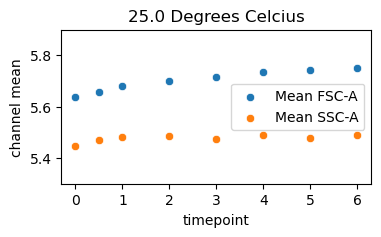

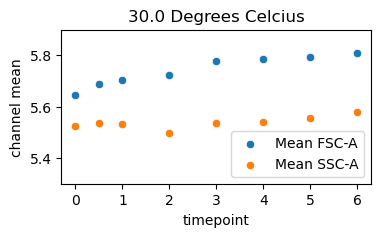

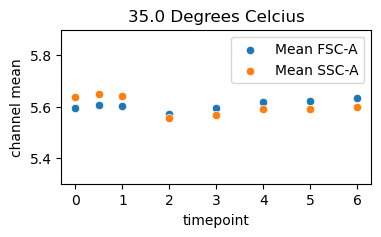

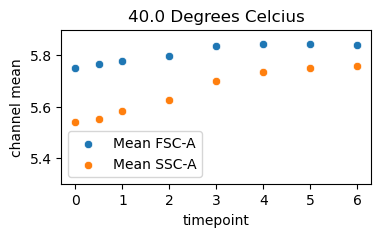

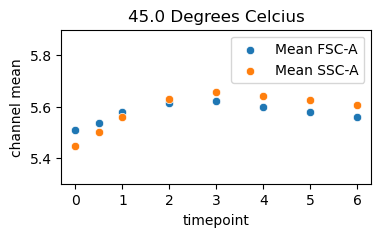

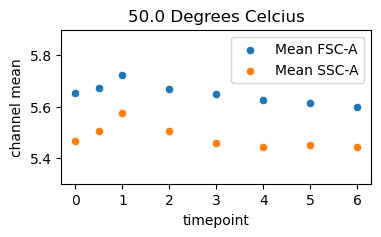

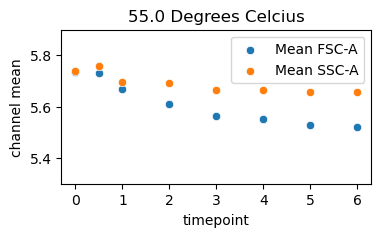

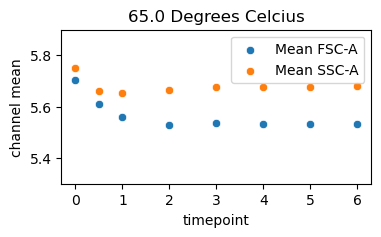

In [13]:
for temp in geo_means["temperature"].unique():
#     count = count+1
    fig = plt.figure(figsize=(4, 2))
    temp_df = geo_means.loc[geo_means["temperature"] == temp]
#     print(temp_df['replicate_group'].value_counts())
    sns.scatterplot(data=temp_df, x="timepoint", y="FSC-A", label="Mean FSC-A")
    sns.scatterplot(data=temp_df, x="timepoint", y="SSC-A", label="Mean SSC-A")
    plt.ylim(5.3, 5.9)
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

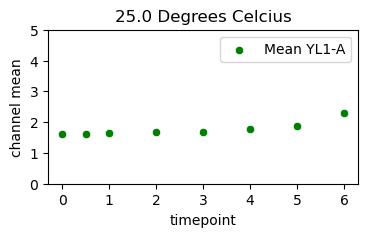

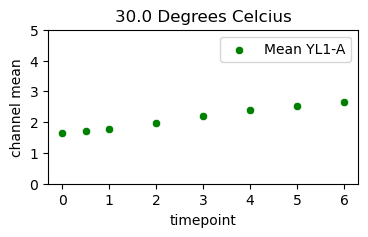

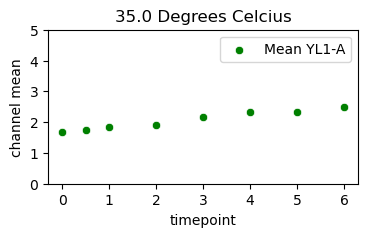

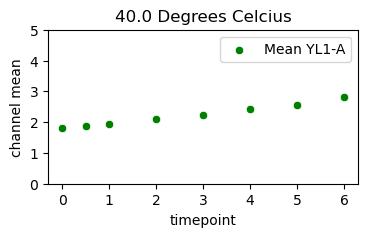

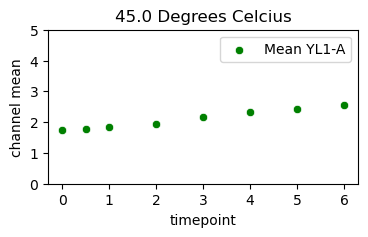

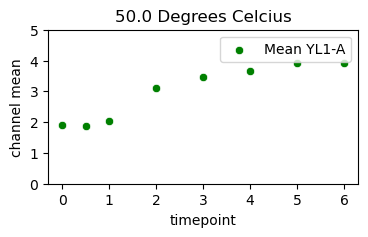

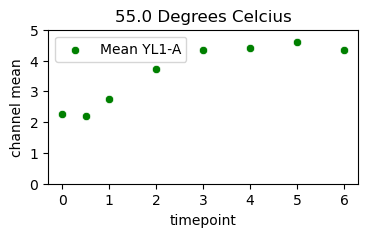

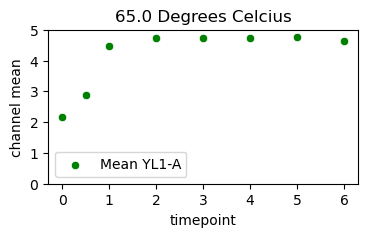

In [15]:
for temp in geo_means["temperature"].unique():
    fig = plt.figure(figsize=(4, 2))
    temp_df = geo_means.loc[geo_means["temperature"] == temp]
    sns.scatterplot(data=temp_df, x="timepoint", y="YL1-A", label="Mean YL1-A", color="g")
    plt.ylim(0, 5)
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

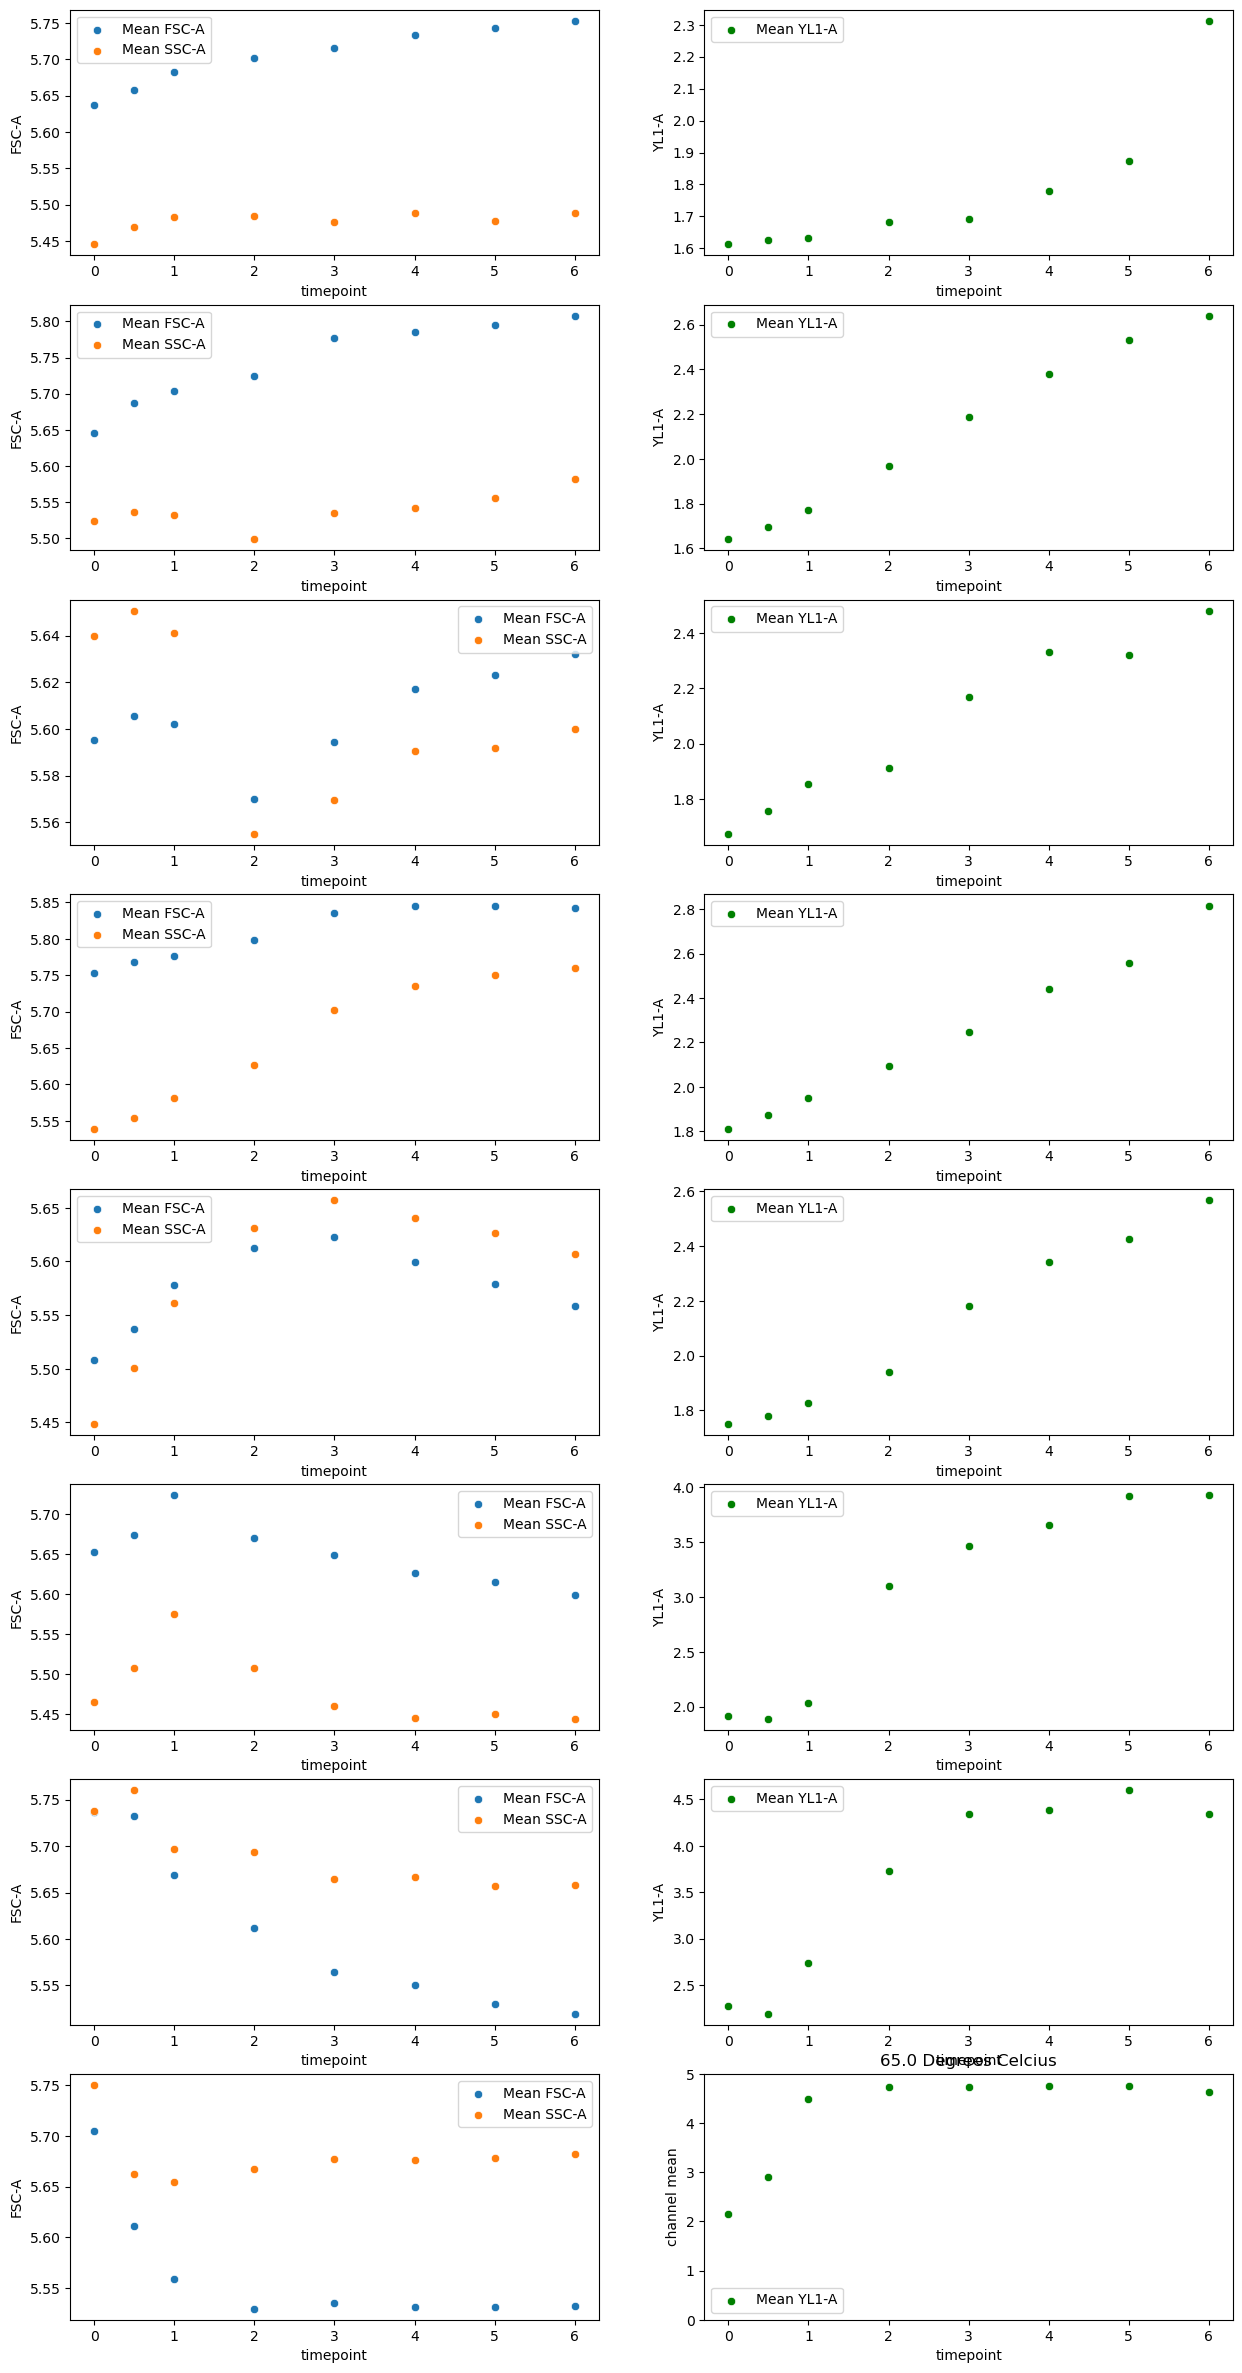

In [16]:
count = 0
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
for temp in geo_means["temperature"].unique():
#     fig = plt.figure(figsize=(4, 2))

    temp_df = geo_means.loc[geo_means["temperature"] == temp]
    sns.scatterplot(data=temp_df, x="timepoint", y="FSC-A", label="Mean FSC-A", ax=axes[count][0])
    sns.scatterplot(data=temp_df, x="timepoint", y="SSC-A", label="Mean SSC-A", ax=axes[count][0])
    plt.ylim(5.3, 5.9)
    
    sns.scatterplot(data=temp_df, x="timepoint", y="YL1-A", label="Mean YL1-A", ax=axes[count][1], color="g")
    plt.ylim(0, 5)

    count = count+1
    plt.legend()
    plt.ylabel("channel mean")
    plt.title("{} Degrees Celcius".format(temp))

In [17]:
set_treatment_column(n.temperature)

df_with_rfc_labels, X, Y = generate_rf_labels_from_conditions(df, features,
                                                              live_conditions=[{'temperature': 25.0,
                                                                               'timepoint': 6.0},
                                                                               {'temperature': 30.0,
                                                                                'timepoint': 6.0},
                                                                               {'temperature': 35.0,
                                                                                'timepoint': 6.0}], 
                                                              dead_conditions=[{'temperature': 65.0,
                                                                                'timepoint': 6.0},
                                                                               {'temperature': 55.0,
                                                                                'timepoint': 6.0}])

Conditions designated as Live: [{'temperature': 25.0, 'timepoint': 6.0}, {'temperature': 30.0, 'timepoint': 6.0}, {'temperature': 35.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'temperature': 65.0, 'timepoint': 6.0}, {'temperature': 55.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 12:16:08
Starting Classification training...
Training time was: 13.01 seconds
Testing time was: 1.74 seconds
Prediction time of untested data was: 24.402106046676636
Run finished at 12:16:54. Total run time = 46.67 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




2023-02-13 13:05:52.509820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


60000/60000 [==============================] - 235s 4ms/step

Model Boosting took 1754.3646569252014 seconds
Training Accuracy = 90.85%
Counter({1: 1174011, 0: 745989})
60000/60000 [==============================] - 237s 4ms/step


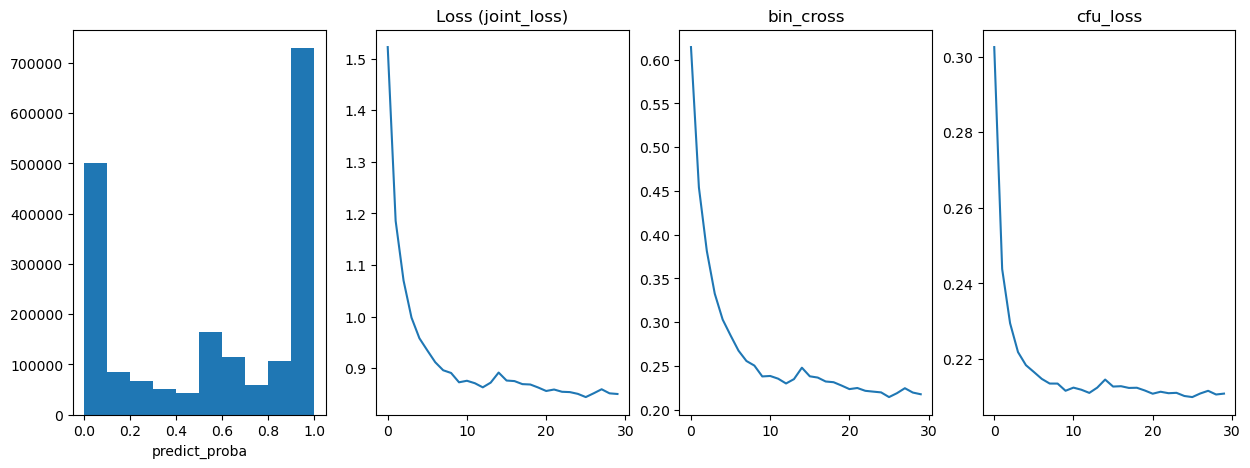

In [18]:
condition_results, preds_and_labels,model = run_model(model_function=booster_model_v2, lr=0.001,
                                                loss = joint_loss_wrapper(3), 
                                                metrics = [bin_cross, cfu_loss],
                                                X = X, Y = Y, epochs = 30, batch_size = 2048,
                                                verbose = False, shuffle = True, plot_type="line")

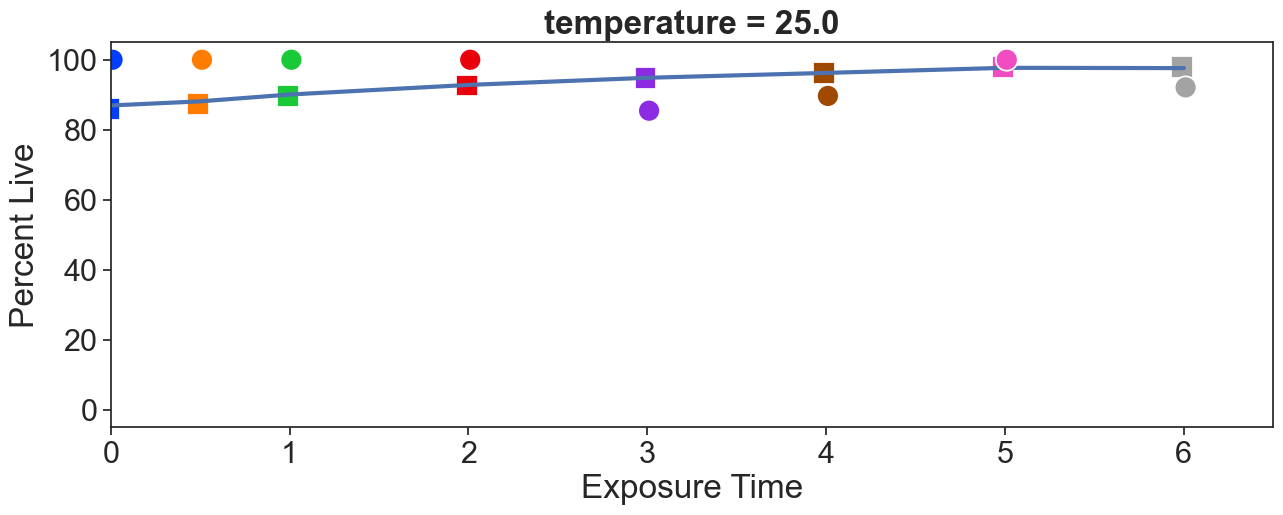

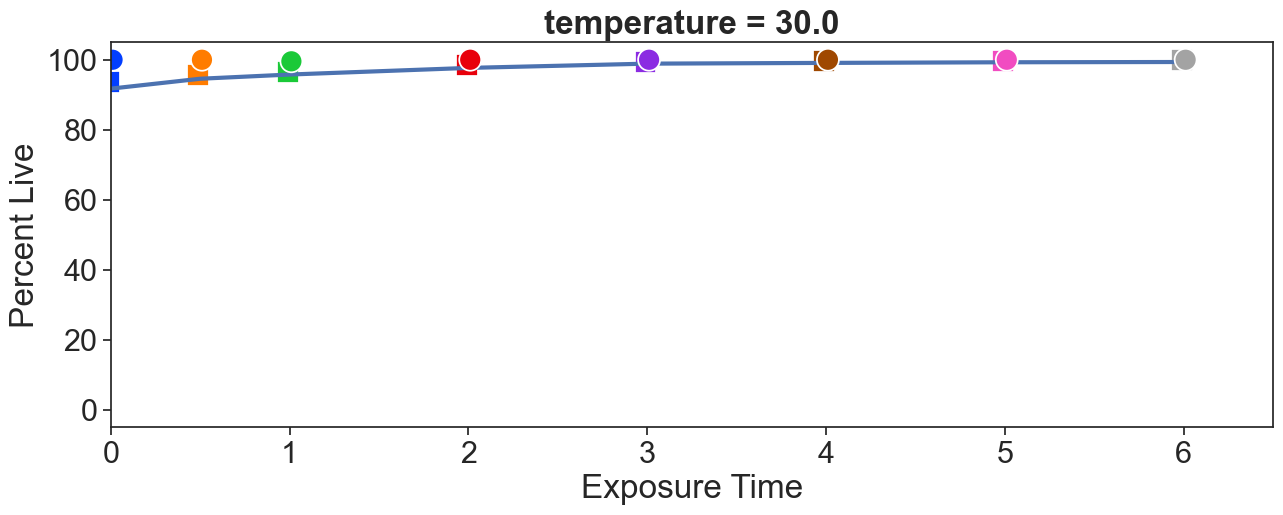

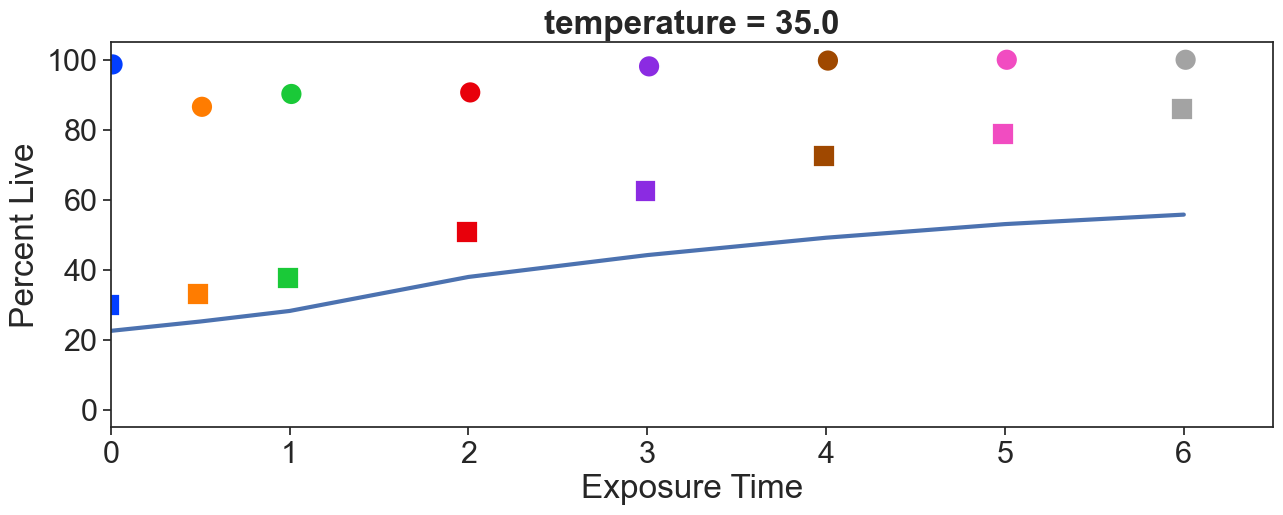

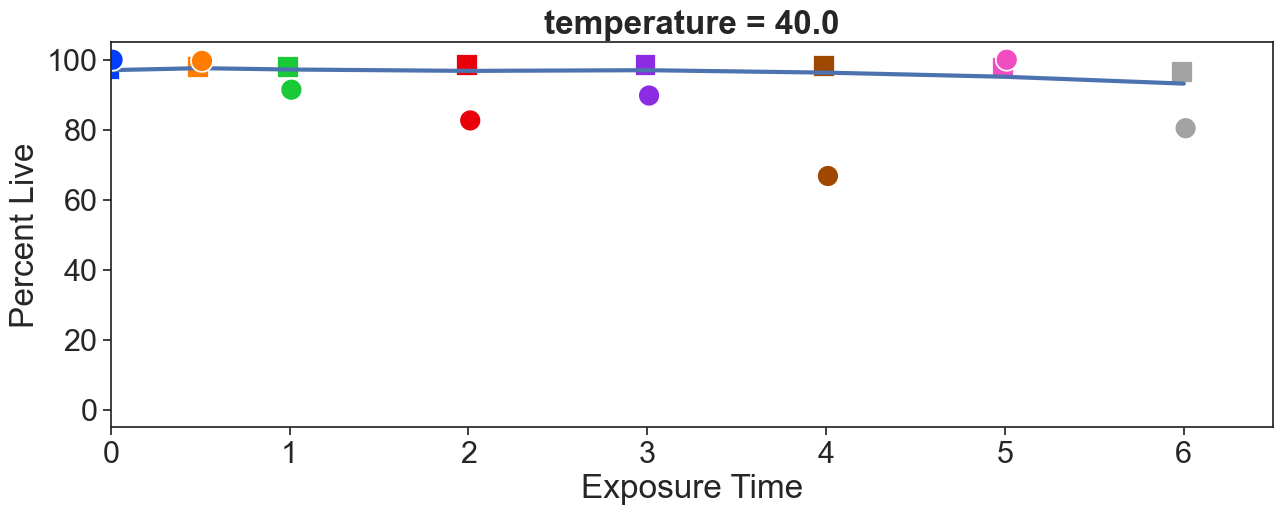

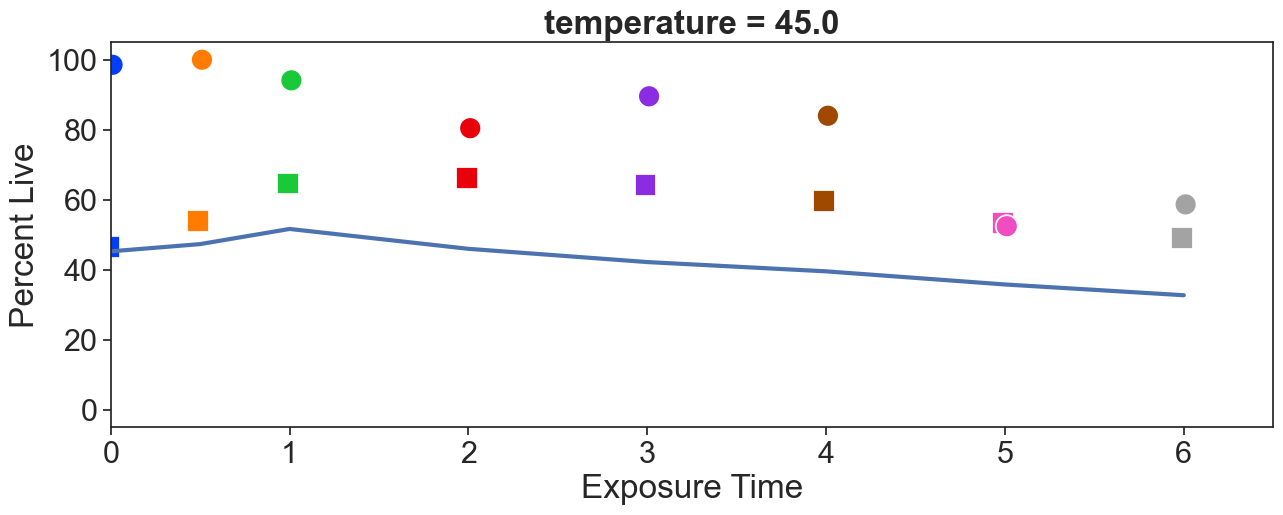

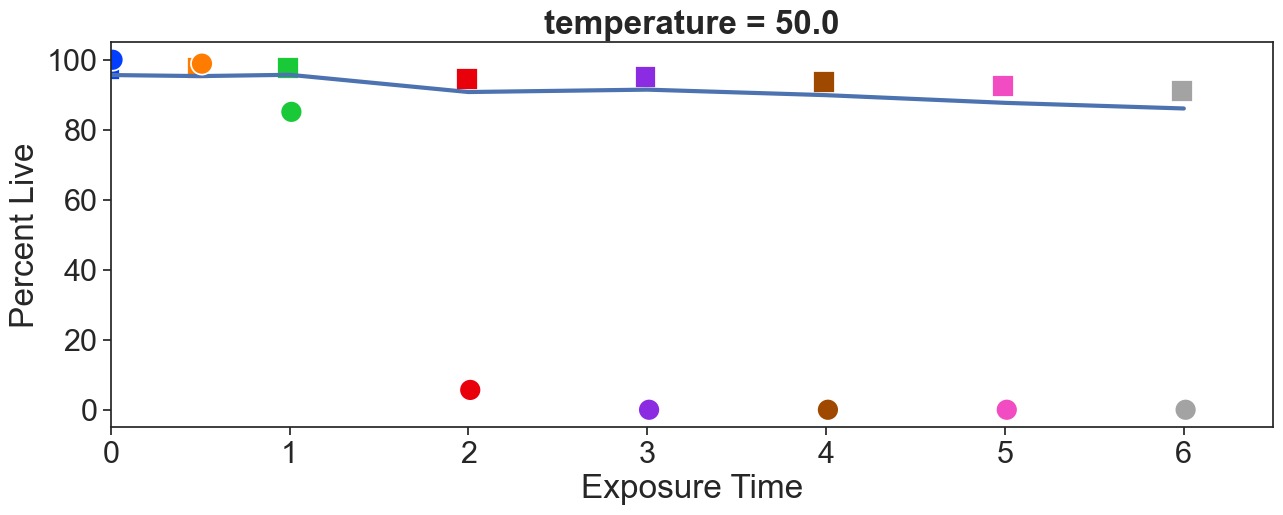

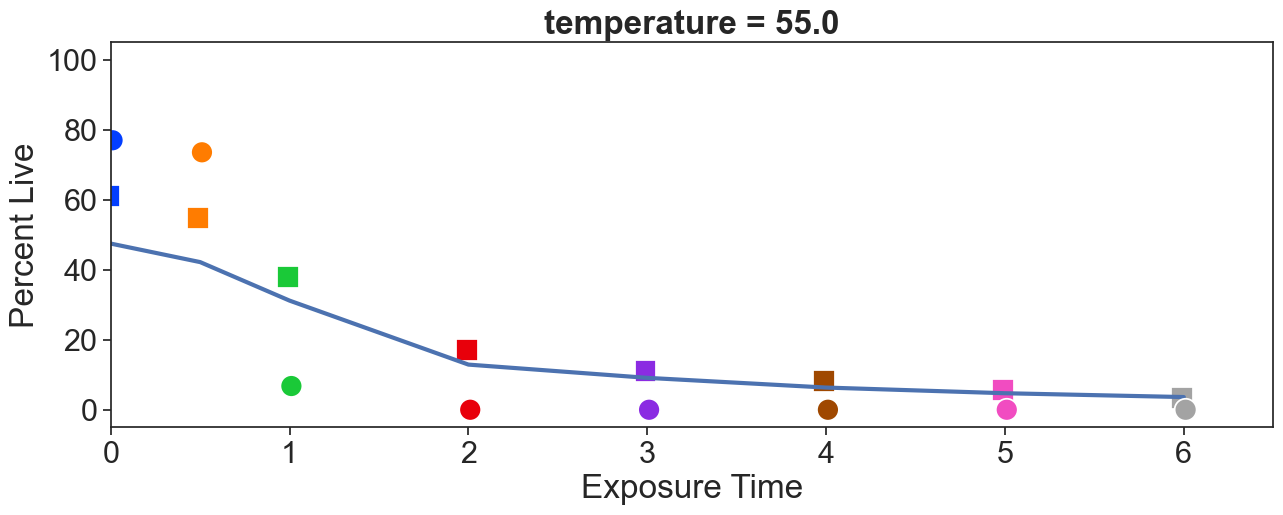

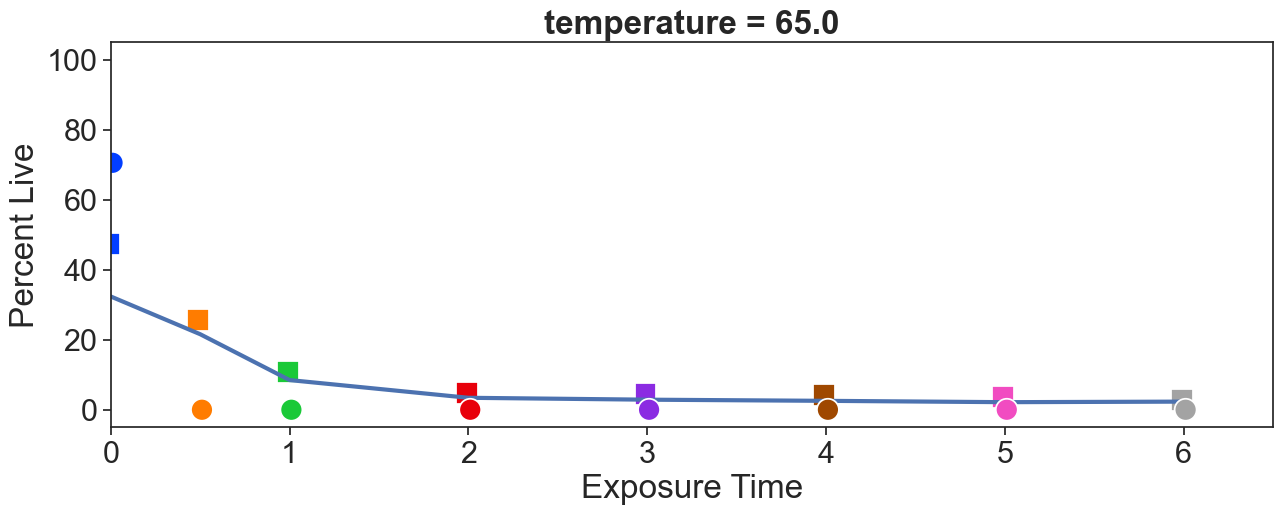

In [19]:
plot_per_cond(condition_results)


In [20]:
condition_results.head(10)

,temperature,timepoint,label,cfu_percent_live,nn_preds
0,25.0,0.0,85.960000,100.000000,86.936667
1,25.0,0.5,87.470000,100.000000,88.113333
2,25.0,1.0,89.746667,100.000000,90.063333
3,25.0,2.0,92.643333,100.000000,92.806667
4,25.0,3.0,94.763333,85.443333,94.846667
5,25.0,4.0,96.273333,89.666667,96.240000
6,25.0,5.0,97.866667,100.000000,97.693333
7,25.0,6.0,98.010000,92.110000,97.613333
8,30.0,0.0,93.580000,100.000000,91.743333
9,30.0,0.5,95.523333,100.000000,94.573333


In [21]:
if use_stain_in_AutoGater:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels)
else:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels,
                                append_df_cols=stain_cols)

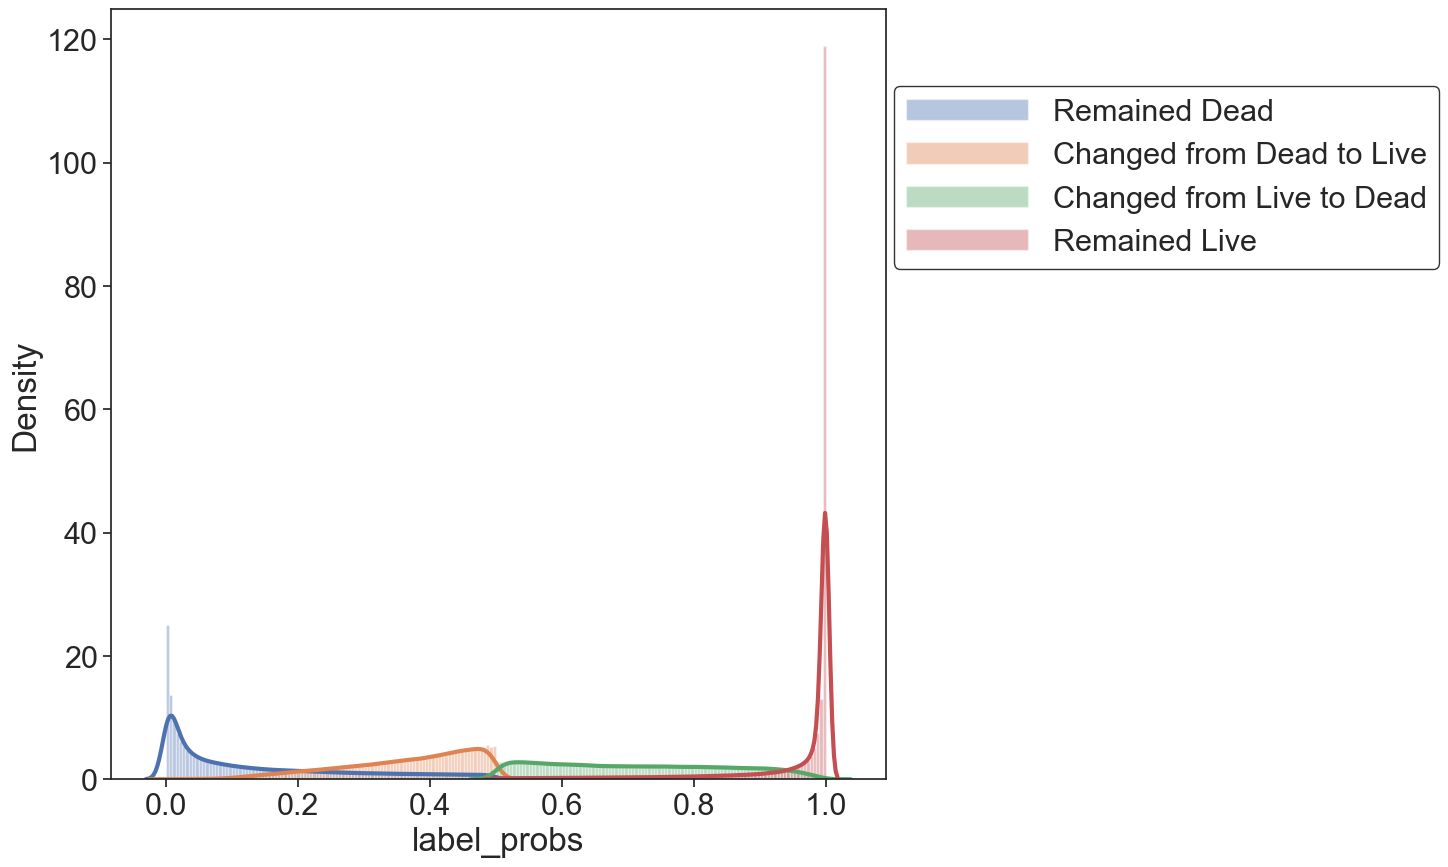

In [22]:
plot_prob_changes(run_info, None)

In [23]:
kde_df = get_conc_df_with_kde_values(run_info,
                                     conc="all",
                                     features=all_features,
                                     cc="{}-H".format(color_channel_to_use))

In [ ]:
final_df = kde_scatter(kde_df, cc="{}-H".format(color_channel_to_use), logged=True,
                       fraction_of_points_based_on_kde=0.9,
                       point_1_that_defines_line=point_1_that_defines_soa_line, 
                       point_2_that_defines_line=point_2_that_defines_soa_line,
                       cmap="Spectral_r", pred_col="nn_preds")

Percent of AutoGater live predictions that are left of the SOA dashed line: 91.07


In [ ]:
summary_table = summary_table_of_results(final_df)

In [ ]:
percent_live_comparison_plot(summary_table, legend=False)

In [ ]:
percent_live_comparison_plot(summary_table, legend=True)